# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


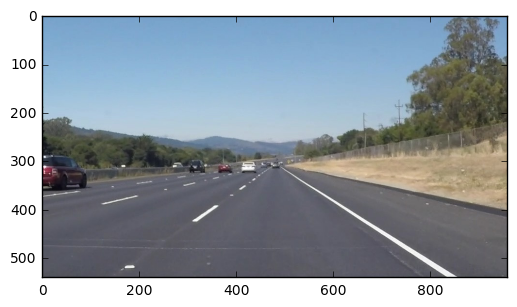

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
#Global variable
old_poly_left = [0,0]
old_poly_right = [0,0]

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def slopes(img, lines):

    pos_slope = []
    neg_slope = []
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0:
                pos_slope.append((x1,y1))
                pos_slope.append((x2,y2))

            else:
                neg_slope.append((x1,y1))
                neg_slope.append((x2,y2))
                  
    if len(pos_slope)>0 and len(neg_slope)>0:
        left = np.array(pos_slope)
        right = np.array(neg_slope)
        
        poly_left = np.polyfit(left[:,0],left[:,1], 1)
        poly_right = np.polyfit(right[:,0],right[:,1], 1)
    else:
        poly_left = np.array([0, 0])
        poly_right = np.array([0, 0])
        
    return poly_left, poly_right


def slopes_compare(poly_left, poly_right, old_poly_left, old_poly_right):
    poly_left_compared = slope_check(old_poly_left, poly_left)
    poly_right_compared = slope_check(old_poly_right, poly_right)
    if poly_left_compared[0]<0:
        poly_left_compared = old_poly_left
    if poly_right_compared[0]>0:
        poly_right_compared = old_poly_right
        
    return poly_left_compared, poly_right_compared
        
        
def slope_check(old_poly, poly):
    max_difference = 0.15
    if old_poly[0]==0:
        return poly
    if abs(old_poly[0]-poly[0])>max_difference:
        return old_poly
    else:
        return poly


def draw_lines(img, poly_left, poly_right, color=[255, 0, 0], thickness=8):        
        y1 = imshape[0]
        y2 = 325
    
        # Right line
        xR1 = x_calc(y1,poly_left[0],poly_left[1])
        xR2 = x_calc(y2,poly_left[0],poly_left[1])
        cv2.line(img, (xR1, y1), (xR2, y2), color, thickness)
    
        # Left line
        xL1 = x_calc(y1,poly_right[0],poly_right[1])
        xL2 = x_calc(y2,poly_right[0],poly_right[1])
        cv2.line(img, (xL1, y1), (xL2, y2), color, thickness)

        
def x_calc(y,m,b):
    return np.int16((y-b)/m)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, old_poly_left, old_poly_right):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    poly_left, poly_right = slopes(img, lines)
    poly_left_compared, poly_right_compared = slopes_compare(poly_left, poly_right, old_poly_left, old_poly_right)

    draw_lines(line_img, poly_left_compared, poly_right_compared)
    return line_img, poly_left_compared, poly_right_compared


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)


def convert_bgr2hsv(img):
# Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of white color in HSV
    lower_white = np.array([0,0,0])
    upper_white = np.array([12,255,255])
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    res1 = cv2.bitwise_and(img,img, mask= mask)
    
    lower_yellow = np.array([90,0,0])
    upper_yellow = np.array([100,255,255])
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    # Bitwise-AND mask and original image
    res2 = cv2.bitwise_and(img,img, mask= mask)
    
    res = cv2.add(res1,res2)
    return res

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve2.jpg',
 'lane_line_whiteCarLaneSwitch.jpg',
 'lane_line_solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'lane_line_solidYellowCurve.jpg',
 'lane_line_solidWhiteCurve.jpg',
 'lane_line_solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'lane_line_solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

True

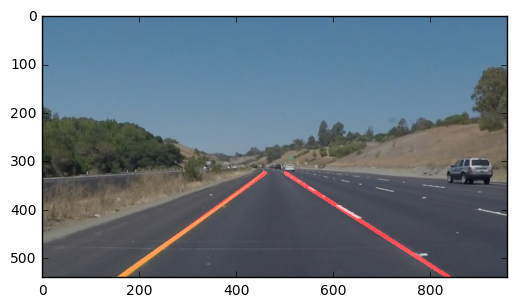

In [5]:
# Load image into file for processing
file = 'solidYellowCurve.jpg'
image = mpimg.imread('test_images/'+file)

# Grayscale the original image
gray_image =grayscale(image)

# Gaussian Smoothing with a variable kernel
kernel_size = 3
gaussian_image = gaussian_blur(gray_image, kernel_size)

# Canny Edge Detection
low_threshold = 85   #1:3 relation of the image quantization
high_threshold = 170 #2:3 relation of the image quantization
canny_image = canny(gaussian_image, low_threshold, high_threshold)

# Get the Region of Interest
imshape = image.shape
vertices = np.array([[(20,imshape[0]),(485, 300), (505, 300), (800,imshape[0])]], dtype=np.int32)
region_image = region_of_interest(canny_image, vertices)

# Hough Transform implementation
rho = 1
theta = np.pi/180
threshold = 40
min_line_len = 50
max_line_gap = 15

hough_image, old_poly_left, old_poly_right = hough_lines(region_image, rho, theta, threshold, min_line_len, max_line_gap, old_poly_left, old_poly_right)

# Blend Image and Hough Transform Image
weighted_image = weighted_img(hough_image, image, α=0.8, β=1, λ=0.)

plt.imshow(weighted_image)

final_image = cv2.cvtColor(weighted_image, cv2.COLOR_RGB2BGR)
cv2.imwrite('test_images/lane_line_'+file,final_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
#import moviepy
from IPython.display import HTML

In [7]:
def process_image(image):
    
    global old_poly_left
    global old_poly_right
       
# Grayscale the original image
    gray_image =grayscale(image)

# Gaussian Smoothing with a variable kernel
    kernel_size = 3
    gaussian_image = gaussian_blur(gray_image, kernel_size)
    
# Canny Edge Detection
    low_threshold = 85   #1:3 relation of the image quantization 85
    high_threshold = 170 #2:3 relation of the image quantization 170

    canny_image = canny(gaussian_image, low_threshold, high_threshold)

# Get the Region of Interest
    imshape = image.shape
    vertices = np.array([[(20,imshape[0]),(485, 300), (485+20, 300), (imshape[1],imshape[0])]], dtype=np.int32)
    region_image = region_of_interest(canny_image, vertices)

# Hough Transform implementation
    rho = 1
    theta = np.pi/180
    threshold = 40
    min_line_len = 50
    max_line_gap = 15

    hough_image, old_poly_left, old_poly_right = hough_lines(region_image, rho, theta, threshold, min_line_len, max_line_gap,old_poly_left, old_poly_right)

# Blend Image and Hough Transform Image
    result = weighted_img(hough_image, image, α=0.8, β=1, λ=0.) 
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
print(old_poly_left)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:23<00:00,  9.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 56 s, sys: 4.67 s, total: 1min
Wall time: 25.6 s
[  0.56342311  37.30618019]


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:19<00:00,  6.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 11s, sys: 15.2 s, total: 3min 26s
Wall time: 1min 20s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

	 	 	
The implementation of the lane finding pipeline was a very satisfying and challenging task. In my case, what really helped was the fact that I did every example presented in Lesson 2, so by doing that, I stepped into different kind of problems that I was able to solve at the moment of occurrence. That approach was very helpful when I implemented the pipeline, because I could isolate the different problems that happened to me during the implementation.

I was able to make my algorithm better by using a HSV transformation of my RGB image (for the challenge video) so I could keep track on the yellow and white lanes, on the downside, my algorithm will fail if the lanes are of different color.

I was able to make my lines with less jitter by discarding slopes were the difference between slopes on two successive frames was greater than some maximum value allowed. Unfortunately the pipeline will fail if the road has many frames without lane lines.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    

def slopes(img, lines):

    pos_slope = []
    neg_slope = []

    try:

        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                if slope > 0:
                    pos_slope.append((x1,y1))
                    pos_slope.append((x2,y2))

                else:
                    neg_slope.append((x1,y1))
                    neg_slope.append((x2,y2))

        if len(pos_slope)>0 and len(neg_slope)>0:
            left = np.array(pos_slope)
            right = np.array(neg_slope)

            poly_left = np.polyfit(left[:,0],left[:,1], 1)
            poly_right = np.polyfit(right[:,0],right[:,1], 1)
        else:
            poly_left = np.array([0, 0])
            poly_right = np.array([0, 0])

        return poly_left, poly_right

    except TypeError:
        return old_poly_left, old_poly_right

    
def slopes_compare(poly_left, poly_right, old_poly_left, old_poly_right):
    poly_left_compared = slope_check(old_poly_left, poly_left)
    poly_right_compared = slope_check(old_poly_right, poly_right)
    if poly_left_compared[0]<0:
        poly_left_compared = old_poly_left
    if poly_right_compared[0]>0:
        poly_right_compared = old_poly_right
        
    return poly_left_compared, poly_right_compared
        
        
def slope_check(old_poly, poly):
    max_difference = 0.05
    if old_poly[0]==0:
        return poly
    if abs(old_poly[0]-poly[0])>max_difference:
        return old_poly
    else:
        return poly

    
def draw_lines(img, poly_left, poly_right, color=[255, 0, 0], thickness=8):        
        y1 = 700
        y2 = 450
    
        # Right line
        xR1 = x_calc(y1,poly_left[0],poly_left[1])
        xR2 = x_calc(y2,poly_left[0],poly_left[1])
        cv2.line(img, (xR1, y1), (xR2, y2), color, thickness)
    
        # Left line
        xL1 = x_calc(y1,poly_right[0],poly_right[1])
        xL2 = x_calc(y2,poly_right[0],poly_right[1])
        cv2.line(img, (xL1, y1), (xL2, y2), color, thickness)

        
def x_calc(y,m,b):
    return np.int16((y-b)/m)
        
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, old_poly_left, old_poly_right):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    poly_left, poly_right = slopes(img, lines)
    poly_left_compared, poly_right_compared = slopes_compare(poly_left, poly_right, old_poly_left, old_poly_right)
    draw_lines(line_img, poly_left, poly_right)
    return line_img, poly_left_compared, poly_right_compared


# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def convert_bgr2hsv(img):
# Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of white color in HSV
    lower_white = np.array([0,0,220])
    upper_white = np.array([130,130,255])
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    res1 = cv2.bitwise_and(img,img, mask= mask)
    
    lower_yellow = np.array([20, 80, 200])
    upper_yellow = np.array([120, 200, 255])
    
    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    # Bitwise-AND mask and original image
    res2 = cv2.bitwise_and(img,img, mask= mask)
    
    res = cv2.add(res1,res2)
    return res


def process_image_challenge(image):
    
    global old_poly_left
    global old_poly_right
    
# HSV the original image
    hsv_image = convert_bgr2hsv(image)

# Grayscale the original image
    #gray_image =grayscale(image)
    gray_image =grayscale(hsv_image)

# Gaussian Smoothing with a variable kernel
    kernel_size = 3
    gaussian_image = gaussian_blur(gray_image, kernel_size)

# Canny Edge Detection
    low_threshold = 85   #1:3 relation of the image quantization
    high_threshold = 100 #2:3 relation of the image quantization
    canny_image = canny(gaussian_image, low_threshold, high_threshold)

# Get the Region of Interest
    imshape = image.shape

    a = [255,652]
    b = [628,421]
    c = [751,421]
    d = [1120,652]
#print("Region of Interest",a,b,c,d)
    vertices = np.array([[a,b,c,d]], dtype=np.int32)
#vertices = np.array([[(20,imshape[0]),(485, 300), (485+20, 300), (800,imshape[0])]], dtype=np.int32)
    region_image = region_of_interest(canny_image, vertices)

# Hough Transform implementation
    rho = 1
    theta = np.pi/180
    threshold = 25
    min_line_len = 25
    max_line_gap = 15

    hough_image, old_poly_left, old_poly_right = hough_lines(region_image, rho, theta, threshold, min_line_len, max_line_gap, old_poly_left, old_poly_right)

# Blend Image and Hough Transform Image
    result = weighted_img(hough_image, image, α=0.8, β=1, λ=0.)
    return result

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:57<00:00,  4.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 2min 6s, sys: 10.4 s, total: 2min 17s
Wall time: 1min


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))